# Dataset pipeline for Early Convnet Approach (Exploration)

Possible leads:
* https://stackoverflow.com/questions/54745903/how-to-implement-an-image2d-array-sequence-sliding-window-in-tensorflow
* https://stackoverflow.com/questions/55429307/how-to-use-windows-created-by-the-dataset-window-method-in-tensorflow-2-0s
* https://stackoverflow.com/questions/38235643/getting-started-with-tensorflow-split-image-into-sub-imagess

Goal:s
> every 40 × 40 window in the input stepped every 4 pixels

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import src.data.datasets.deep_globe_2018
import PIL
import math

ds, ds_info = tfds.load(
        # Useful link: https://github.com/tensorflow/datasets/issues/2680#issuecomment-778801923
        name='deep_globe_2018',
        download=False,
        with_info=True,
    )

ds_info

2023-12-27 19:30:05.814784: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-12-27 19:30:10.634487: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


tfds.core.DatasetInfo(
    name='deep_globe_2018',
    full_name='deep_globe_2018/1.0.0',
    description="""
    TODO(deep_globe_2018): Markdown description of that will appear on the catalog page.
    Description is **formatted** as markdown.
    
    It should also contain any processing which has been applied (if any),
    (e.g. corrupted example skipped, images cropped,...):
    """,
    homepage='https://dataset-homepage/',
    data_path='/root/tensorflow_datasets/deep_globe_2018/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=1.95 GiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'all_images': <SplitInfo num_examples=803, num_shards=16>,
    },
    citation="""// TODO(deep_globe_2018):

In [2]:
def load_image(datapoint):
    tile_size = [32, 32]
    padding="CONSTANT"
    
    input_image = tf.image.resize(datapoint['image'], (512, 512))
    image_shape = input_image.shape

    ## TODO: RESUME EXPLORATION HERE, managed to split iamge into tiles
    imagesize = image_shape[0:2]
    
    tile_rows = tf.reshape(input_image, [image_shape[0], -1, tile_size[1], image_shape[2]])
    serial_tiles = tf.transpose(tile_rows, [1, 0, 2, 3])

    print(tf.reshape(serial_tiles, [-1, tile_size[1], tile_size[0], image_shape[2]]).shape)
    
    input_mask = tf.image.resize(
        datapoint['segmentation_mask'],
        (512, 512),
        method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
    )
    a
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [3]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [51]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    print(len(display_list))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [58]:
patch_size = 256
def load_patches(datapoint):
    img_patches = tf.image.extract_patches(
        images = datapoint['image'],
        sizes = [1, patch_size, patch_size, 1],
        strides = [1, patch_size, patch_size, 1],
        rates = [1, 1, 1, 1],
        padding = 'VALID'
    )
    img_patches_flat = tf.reshape(img_patches, shape=(-1, patch_size, patch_size, 3))

    ann_patches = tf.image.extract_patches(
        images = datapoint['segmentation_mask'],
        sizes = [1, patch_size, patch_size, 1],
        strides = [1, patch_size, patch_size, 1],
        rates = [1, 1, 1, 1],
        padding = 'VALID'
    )
    ann_patches_flat = tf.reshape(ann_patches, shape=(-1, patch_size, patch_size, 1))

    img_patches_flat, ann_patches_flat = normalize(img_patches_flat, ann_patches_flat)
    print(img_patches_flat.shape)

    return img_patches_flat, ann_patches_flat

(None, 256, 256, 3)
2


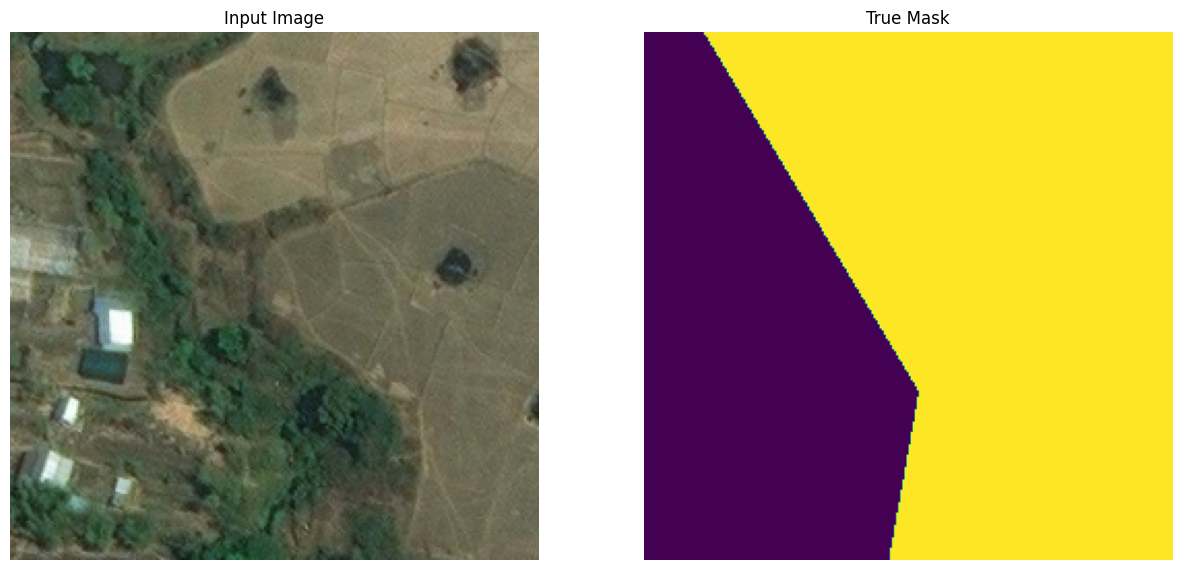

2


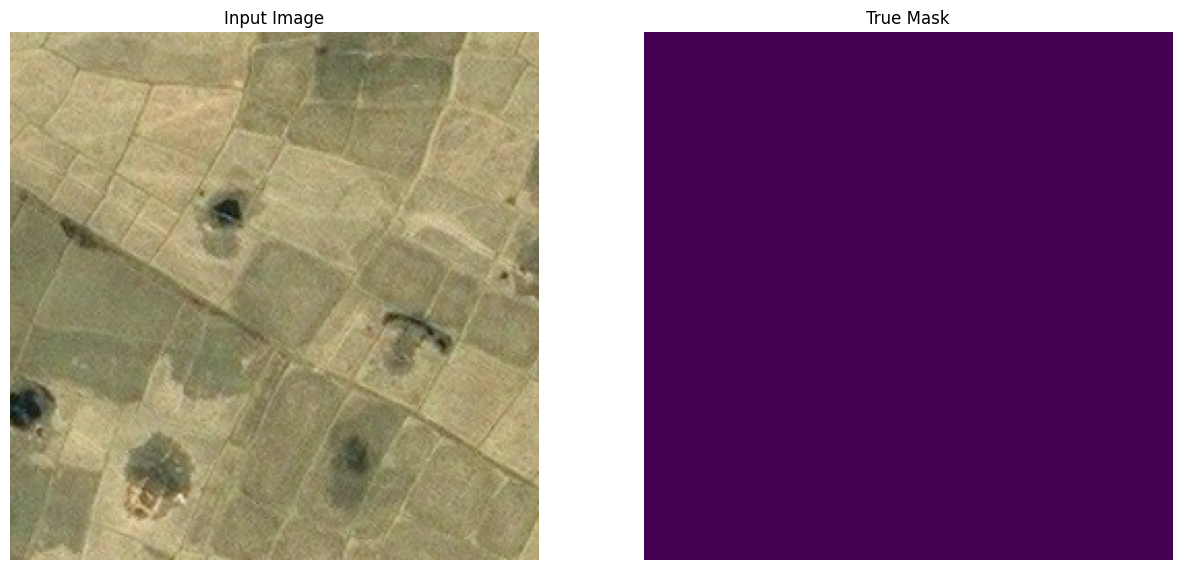

2


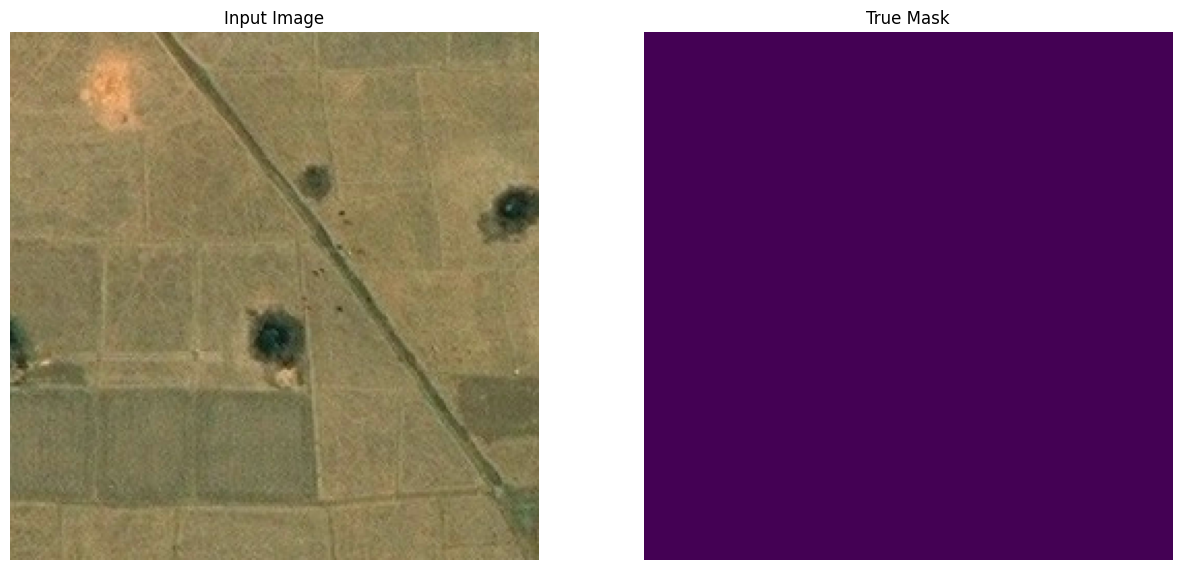

2


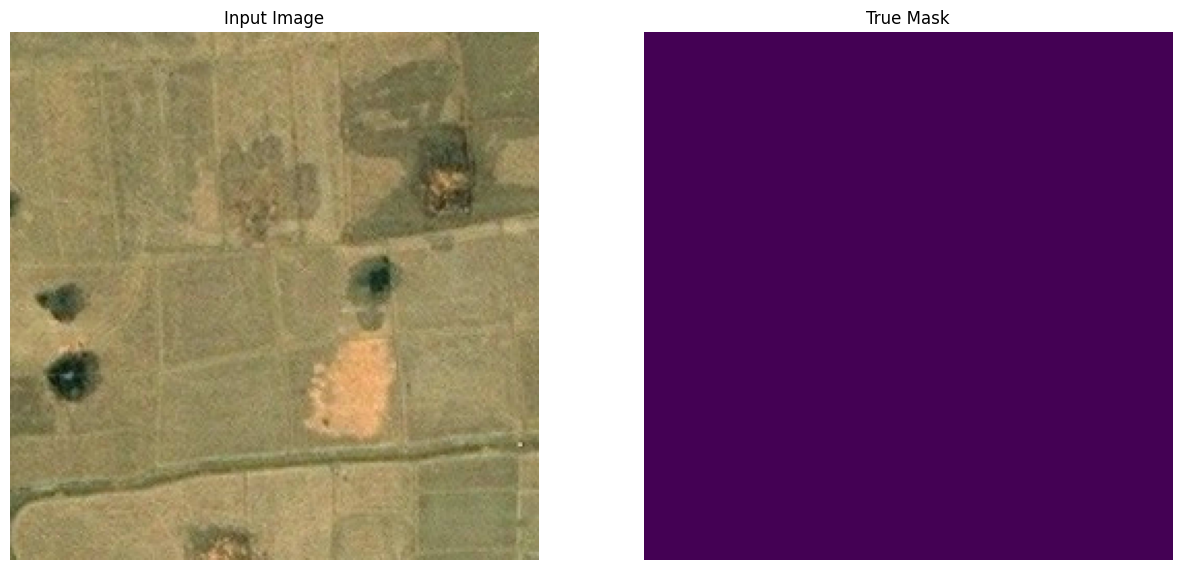

2


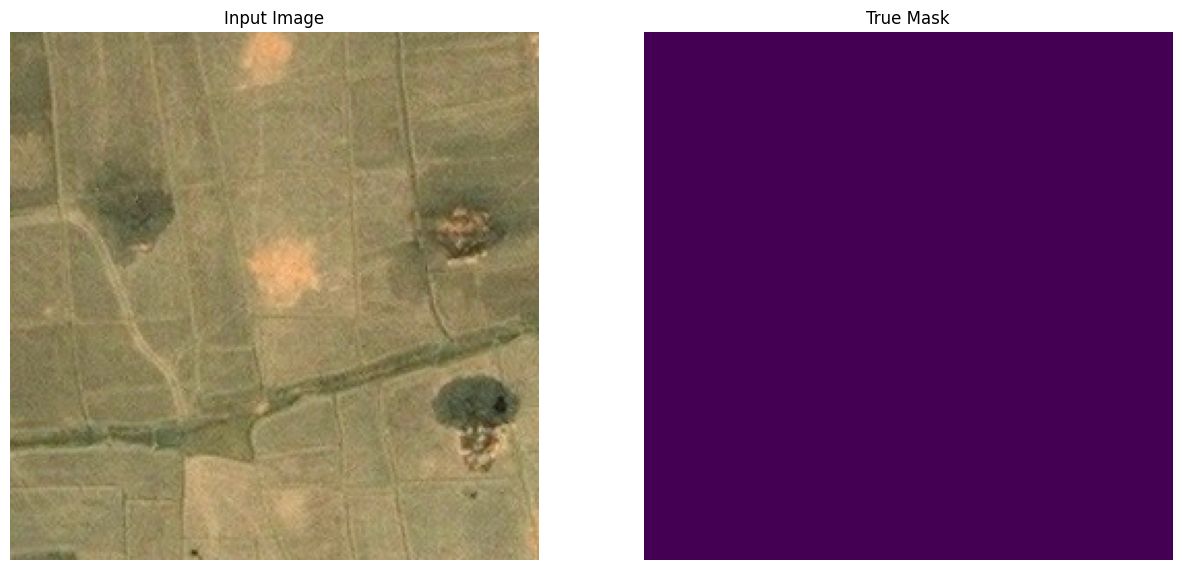

In [61]:
image_batches = (
    ds['all_images']
    .take(1)
    .batch(1)
    .map(load_patches, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
for i, m in image_batches.take(1):
    sample_images = i[70:75]
    sample_masks = m[70:75]
    samples = list(zip(sample_images, sample_masks))
    for sample in samples:
        display(sample)
    # sample_image, sample_mask = i[index], m[index]

(256, 32, 32, 3)
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 512, 512, 1), dtype=tf.uint8, name=None))>


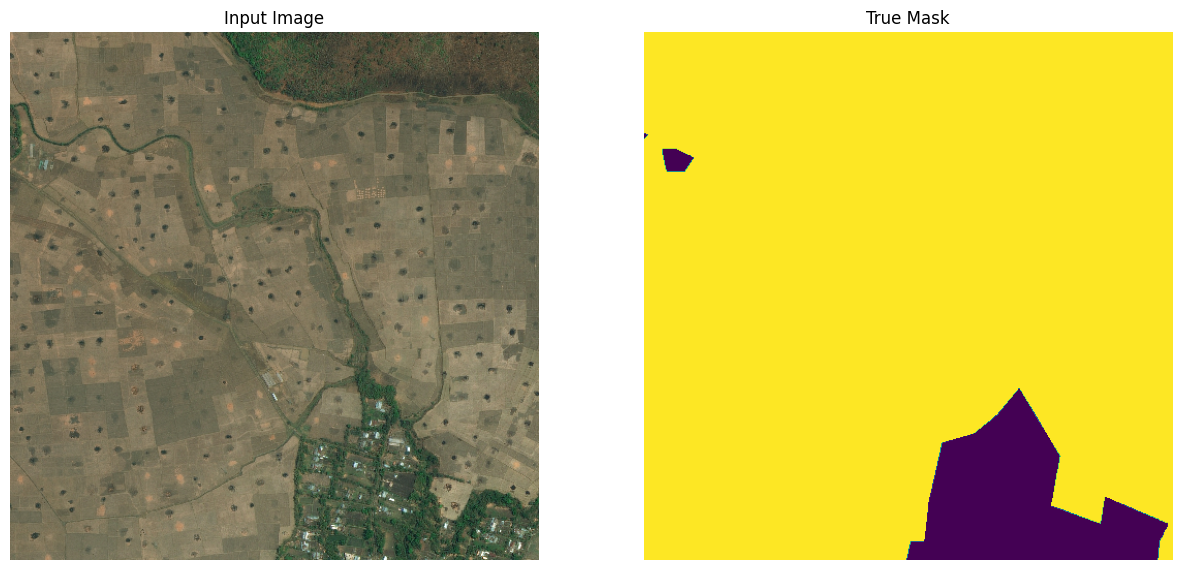

2023-12-27 19:03:22.551825: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


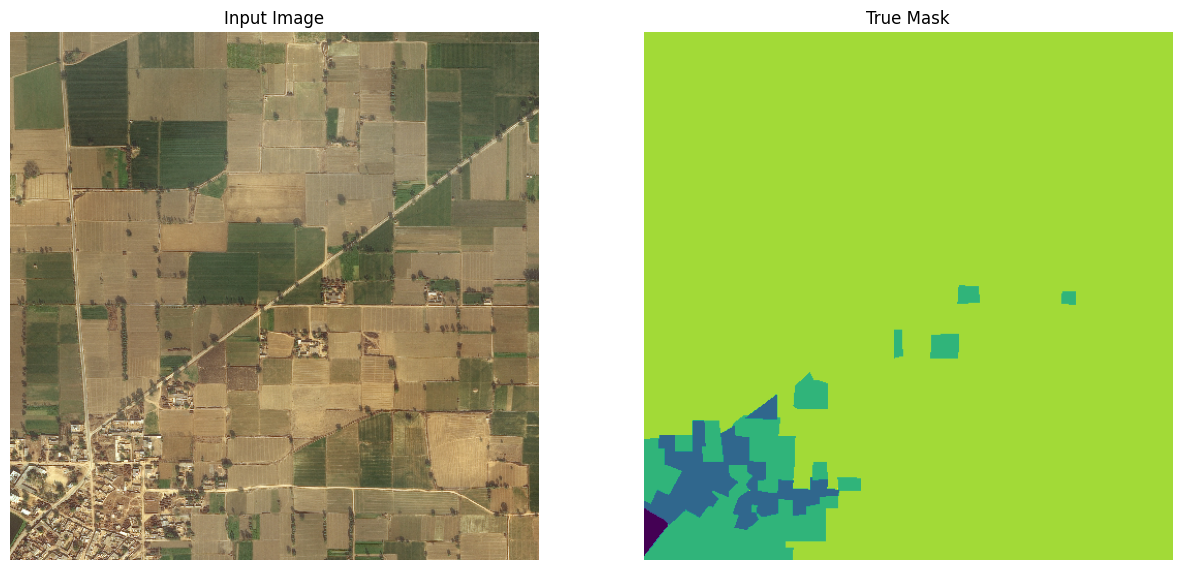

In [37]:
images = ds['all_images'].take(10).map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

image_batches = (
    images
    .cache() # The first time the dataset is iterated over, its elements will be cached either in the specified file or in memory. Subsequent iterations will use the cached data.
    .batch(1) # Combines consecutive elements of this dataset into batches.
    .prefetch(buffer_size=tf.data.AUTOTUNE))

print(image_batches)
for i, m in image_batches.take(2):
    sample_image, sample_mask = i[0], m[0]
    display([sample_image, sample_mask])